In this exercise we will train some neural network using Pytorch.
Installation instructions: https://pytorch.org/get-started/locally/

I recommend to run this exercise in colab using GPU or in kaggle notebooks.
You should find something like: Runtime -> Change runtime type -> T4 GPU to access GPU there.
Everything thing you need is preinstalled there.


In [1]:
# Because outside world is ugly (in console 'export OMP_NUM_THREADS=1')
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
# Pytorch is library for dealing with neural networks (and automatic gradients)
import torch
import torch.nn as nn
import torch.nn.functional as F
# Torchvision is helper library for pytorch to deal with computer vision
import torchvision

import matplotlib.pyplot as plt

In [3]:
"""Prepare dataset, whole lecture will be done over MNIST dataset"""
batch_size_train = 256
batch_size_test = 1024

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
# What is in train?
for x, y in train_loader:
    print(x.shape, y.shape, y[:10])
    break

torch.Size([256, 1, 28, 28]) torch.Size([256]) tensor([3, 4, 5, 7, 7, 2, 8, 9, 1, 5])


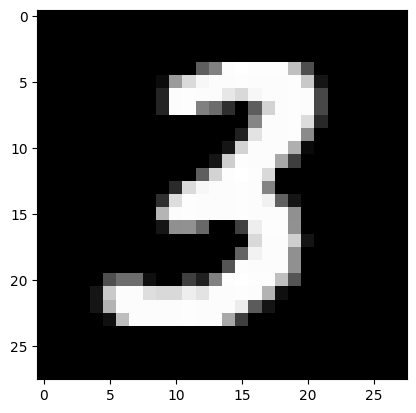

In [5]:
# X: 256 images, 1 channel (black/white), 28x28 image
# We will flatten each image into one vector for now
# Y: One number (category of image)
# Images looks like this:

plt.imshow(x[0,0], cmap="gray")

In [6]:
# Simple linear model (multiclass logistic regression)
# This just computes scores for each class
# This layer has parameters W, b and does (input.matmul(W.T) + b)
model_linear = nn.Linear(28*28, 10)
[(name, p.shape) for name, p in model_linear.named_parameters()]

[('weight', torch.Size([10, 784])), ('bias', torch.Size([10]))]

In [7]:
# Let's compute loss for one batch of images
output = model_linear(x.flatten(1))
log_probs = F.log_softmax(output, dim=-1)    # log_softmax(.) = log(softmax(.))
loss = F.nll_loss(log_probs, y)
loss

tensor(2.5201, grad_fn=<NllLossBackward0>)

In [8]:
# Pytorch has many loss functions, which look similar but take different things,
# so take care
# Here cross entropy(output, y) is same as nll_loss(log_softmax(output), y)
loss2 = F.cross_entropy(output, y)
loss2

tensor(2.5201, grad_fn=<NllLossBackward0>)

In [9]:
# If we want to train model, we need to get gradients
# This is easy, gradient will magically appear
loss.backward()
model_linear.weight.grad

# If you really want to do things by hand, you can do
# model_linear.weight.data = model_linear.weight.data - 0.01 * model_linear.weight.grad

tensor([[ 0.0039,  0.0039,  0.0039,  ...,  0.0039,  0.0039,  0.0039],
        [ 0.0054,  0.0054,  0.0054,  ...,  0.0054,  0.0054,  0.0054],
        [ 0.0156,  0.0156,  0.0156,  ...,  0.0156,  0.0156,  0.0156],
        ...,
        [ 0.0195,  0.0195,  0.0195,  ...,  0.0195,  0.0195,  0.0195],
        [-0.0023, -0.0023, -0.0023,  ..., -0.0023, -0.0023, -0.0023],
        [-0.0013, -0.0013, -0.0013,  ..., -0.0013, -0.0013, -0.0013]])

In [10]:
# Technical Pytorch note:
# If we calculate gradient second time, it will accumulate, so we need to zero it out between steps (.zero_grad())
output = model_linear(x.flatten(1))
log_probs = F.log_softmax(output, dim=-1)    # log_softmax(.) = log(softmax(.))
loss = F.nll_loss(log_probs, y)
loss.backward()
model_linear.weight.grad

tensor([[ 0.0078,  0.0078,  0.0078,  ...,  0.0078,  0.0078,  0.0078],
        [ 0.0108,  0.0108,  0.0108,  ...,  0.0108,  0.0108,  0.0108],
        [ 0.0312,  0.0312,  0.0312,  ...,  0.0312,  0.0312,  0.0312],
        ...,
        [ 0.0391,  0.0391,  0.0391,  ...,  0.0391,  0.0391,  0.0391],
        [-0.0046, -0.0046, -0.0046,  ..., -0.0046, -0.0046, -0.0046],
        [-0.0027, -0.0027, -0.0027,  ..., -0.0027, -0.0027, -0.0027]])

In [11]:
# Lets optimize, this is typical pytorch training loop you will see a lot with some modifications
model_linear = nn.Linear(28*28, 10)
optimizer = torch.optim.SGD(model_linear.parameters(), lr=1)

# Epoch -> one pass through data
for epoch in range(5):
    total_loss = 0
    total_loss_cc = 0
    # Go through data, one chunk at a time
    for x, y in train_loader:
        # Here we calculate output from the model, note that we flatten the input (converts 256,1,28,28 to 256,784) 
        output = model_linear(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        # Here we calculate loss
        batch_loss = F.nll_loss(log_probs, y)
        # Here we calculate gradients, first we need to zero previous ones
        optimizer.zero_grad()
        batch_loss.backward()
        # And here we update the weights
        optimizer.step()
        total_loss += batch_loss.item()
        total_loss_cc += 1
    print("epoch", epoch, "training loss", total_loss / total_loss_cc)

epoch 0 training loss 2.0625456783365697
epoch 1 training loss 1.215319841339233
epoch 2 training loss 1.1928162664175033
epoch 3 training loss 1.138574459070855
epoch 4 training loss 1.1172642455456105


In [12]:
# Optimize and compute training accuracy and test accuracy
# Same loops as above, but we also calculate accuracy on training and testing dataset

model_linear = nn.Linear(28*28, 10)
optimizer = torch.optim.SGD(model_linear.parameters(), lr=1)

for epoch in range(10):
    total_loss = 0
    total_loss_cc = 0
    total_good = 0
    total_samples = 0
    
    for x, y in train_loader:
        output = model_linear(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        # This calulcates accuracy
        prediction = log_probs.argmax(dim=-1)
        total_good += (prediction == y).sum().item()
        total_samples += y.shape[0]
        
        batch_loss = F.nll_loss(log_probs, y)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
        total_loss_cc += 1
        
    total_good_test = 0
    total_samples_test = 0
    for x, y in test_loader:
        output = model_linear(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good_test += (prediction == y).sum().item()
        total_samples_test += y.shape[0]
        
    print("epoch", epoch, "training loss %.3f" % (total_loss / total_loss_cc), 
          "training accuracy %.3f" % (total_good / total_samples), 
          "testing accuracy %.3f" % (total_good_test / total_samples_test))

epoch 0 training loss 1.978 training accuracy 0.835 testing accuracy 0.889
epoch 1 training loss 1.339 training accuracy 0.866 testing accuracy 0.840
epoch 2 training loss 1.177 training accuracy 0.876 testing accuracy 0.875
epoch 3 training loss 1.100 training accuracy 0.881 testing accuracy 0.856
epoch 4 training loss 1.120 training accuracy 0.880 testing accuracy 0.905
epoch 5 training loss 1.074 training accuracy 0.882 testing accuracy 0.897
epoch 6 training loss 1.074 training accuracy 0.882 testing accuracy 0.880
epoch 7 training loss 1.113 training accuracy 0.884 testing accuracy 0.870
epoch 8 training loss 1.006 training accuracy 0.888 testing accuracy 0.879
epoch 9 training loss 0.984 training accuracy 0.887 testing accuracy 0.848


In [13]:
# This is how you define a simple neural network in Pytorch

model = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

model(torch.randn((10,28*28)))

tensor([[ 3.5141e-01, -2.0748e-01, -1.0756e-03, -2.1632e-01, -1.0040e-01,
          3.0737e-01, -2.6616e-01, -2.8018e-01, -2.1607e-01, -2.8872e-02],
        [ 2.7604e-01, -6.2164e-01, -2.4225e-01, -2.2411e-01,  1.0770e-01,
         -1.0322e-01, -6.1034e-02, -1.9223e-01,  2.8147e-01,  8.7966e-02],
        [ 1.2917e-01, -8.3329e-02, -5.8314e-02, -3.6307e-01, -1.7567e-01,
          1.3651e-01,  8.4055e-03, -2.0000e-01, -2.6895e-01, -1.7928e-01],
        [ 3.2809e-01, -2.9825e-01, -2.5020e-01,  1.1890e-01,  2.7453e-01,
          1.2359e-01, -1.1562e-01, -1.7527e-01, -3.1563e-01, -1.4746e-01],
        [ 2.8128e-01, -5.0026e-01, -2.6272e-01, -3.2388e-01,  1.7677e-01,
          1.7635e-01,  9.7864e-02, -2.5453e-01, -3.9661e-02, -3.1104e-01],
        [ 1.9265e-01, -2.3433e-01, -2.6200e-01, -5.5415e-02,  7.8274e-02,
         -4.1907e-01,  1.7463e-01,  2.6926e-01, -6.1750e-02, -1.9966e-01],
        [ 3.3291e-01, -4.9972e-01, -4.0462e-01, -6.2620e-02, -1.2973e-01,
         -2.9446e-04, -4.1391e-0

In [14]:
# Let's train neural network, we only change model and maybe learning rate

model = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)
optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.0)

for epoch in range(10):
    total_loss = 0
    total_loss_cc = 0
    total_good = 0
    total_samples = 0
    
    for x, y in train_loader:
        output = model(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good += (prediction == y).sum().item()
        total_samples += y.shape[0]
        
        batch_loss = F.nll_loss(log_probs, y)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
        total_loss_cc += 1
        
    total_good_test = 0
    total_samples_test = 0
    for x, y in test_loader:
        output = model(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good_test += (prediction == y).sum().item()
        total_samples_test += y.shape[0]
        
    print("epoch", epoch, "training loss %.3f" % (total_loss / total_loss_cc), 
          "training accuracy %.3f" % (total_good / total_samples), 
          "testing accuracy %.3f" % (total_good_test / total_samples_test))

epoch 0 training loss 1.687 training accuracy 0.496 testing accuracy 0.495
epoch 1 training loss 1.145 training accuracy 0.596 testing accuracy 0.652
epoch 2 training loss 0.714 training accuracy 0.775 testing accuracy 0.758
epoch 3 training loss 0.422 training accuracy 0.889 testing accuracy 0.779
epoch 4 training loss 0.371 training accuracy 0.905 testing accuracy 0.866
epoch 5 training loss 0.297 training accuracy 0.920 testing accuracy 0.839
epoch 6 training loss 0.248 training accuracy 0.932 testing accuracy 0.939
epoch 7 training loss 0.197 training accuracy 0.945 testing accuracy 0.945
epoch 8 training loss 0.177 training accuracy 0.949 testing accuracy 0.906
epoch 9 training loss 0.173 training accuracy 0.952 testing accuracy 0.932


In [15]:
"""
# How to run on cuda (this optional, if you have GPU access, e.g. in colab or kaggle notebooks)
# No need to run this cell

model = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)
# Move model to GPU. Instead of x.cuda() you can also use x.to(device) where device is "cpu" or "cuda" so your code
# is nicely parametrized.

model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in range(10):
    total_loss = 0
    total_loss_cc = 0
    total_good = 0
    total_samples = 0
    
    for x, y in train_loader:
        # Move input and labels to GPU
        output = model(x.cuda().flatten(1))
        y = y.cuda()
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good += (prediction == y).sum().item()
        total_samples += y.shape[0]
        
        batch_loss = F.nll_loss(log_probs, y)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
        total_loss_cc += 1
        
    total_good_test = 0
    total_samples_test = 0
    for x, y in test_loader:
        # Move input and labels to GPU
        y = y.cuda()
        output = model(x.cuda().flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good_test += (prediction == y).sum().item()
        total_samples_test += y.shape[0]
        
    print("epoch", epoch, "training loss %.3f" % (total_loss / total_loss_cc), 
          "training accuracy %.3f" % (total_good / total_samples), 
          "testing accuracy %.3f" % (total_good_test / total_samples_test))
          
"""

'\n# How to run on cuda (this optional, if you have GPU access, e.g. in colab or kaggle notebooks)\n# No need to run this cell\n\nmodel = nn.Sequential(\n    nn.Linear(28*28, 256),\n    nn.ReLU(),\n    nn.Linear(256, 10)\n)\n# Move model to GPU. Instead of x.cuda() you can also use x.to(device) where device is "cpu" or "cuda" so your code\n# is nicely parametrized.\n\nmodel.cuda()\noptimizer = torch.optim.SGD(model.parameters(), lr=0.1)\n\nfor epoch in range(10):\n    total_loss = 0\n    total_loss_cc = 0\n    total_good = 0\n    total_samples = 0\n    \n    for x, y in train_loader:\n        # Move input and labels to GPU\n        output = model(x.cuda().flatten(1))\n        y = y.cuda()\n        log_probs = F.log_softmax(output, dim=-1)\n        \n        prediction = log_probs.argmax(dim=-1)\n        total_good += (prediction == y).sum().item()\n        total_samples += y.shape[0]\n        \n        batch_loss = F.nll_loss(log_probs, y)\n        optimizer.zero_grad()\n        batch_

In [16]:
"""
Task 1.
In example above figure out best settings for learning rate a momentum in the optimizer.
Typical values for momentum are something like 0.8, 0.9, 0.95, 0.99.
Keep the number of epochs to 10. Also keep the learning constant during training.
Sumarize your findings in some chart or table.
"""

'\nTask 1.\nIn example above figure out best settings for learning rate a momentum in the optimizer.\nTypical values for momentum are something like 0.8, 0.9, 0.95, 0.99.\nKeep the number of epochs to 10. Also keep the learning constant during training.\nSumarize your findings in some chart or table.\n'

In [17]:
"""
Task 2.
Here is network with 3 hidden layers (each additional hidden layer we add nn.Linear(256,256) and nn.ReLU())

model = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

How does adding more hidden layers influence final accuracy (try 3-6 hidden layers).
Always figure out the best optimizer settings. Again run for 10 epochs.
Again produce some chart or table (maybe with accuracy changes over time).
"""

'\nTask 2.\nHere is network with 3 hidden layers (each additional hidden layer we add nn.Linear(256,256) and nn.ReLU())\n\nmodel = nn.Sequential(\n    nn.Linear(28*28, 256),\n    nn.ReLU(),\n    nn.Linear(256, 256),\n    nn.ReLU(),\n    nn.Linear(256, 256),\n    nn.ReLU(),\n    nn.Linear(256, 10)\n)\n\nHow does adding more hidden layers influence final accuracy (try 3-6 hidden layers).\nAlways figure out the best optimizer settings. Again run for 10 epochs.\nAgain produce some chart or table (maybe with accuracy changes over time).\n'

In [18]:
"""
Here is an example of a simple convolutional network. They are really good on images.
E.g. ResNet is a very strong baseline for any image task https://pytorch.org/vision/main/models/resnet.html
Or convnext: https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/convnext.py

You do not need this for the exercise it is just a reference.

model = nn.Sequential(
    nn.Conv2d(1, 16, 5, padding=2, stride=2),  # Here we get 14x14 image with 16 channels
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, padding='same'),
    nn.ReLU(),
    nn.Conv2d(16, 32, 3, padding=1, stride=2),  # Here we get 7x7 image with 32 channels
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding='same'),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(7*7*32, 10)
)
"""

"\nHere is an example of a simple convolutional network. They are really good on images.\nE.g. ResNet is a very strong baseline for any image task https://pytorch.org/vision/main/models/resnet.html\nOr convnext: https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/convnext.py\n\nYou do not need this for the exercise it is just a reference.\n\nmodel = nn.Sequential(\n    nn.Conv2d(1, 16, 5, padding=2, stride=2),  # Here we get 14x14 image with 16 channels\n    nn.ReLU(),\n    nn.Conv2d(16, 16, 3, padding='same'),\n    nn.ReLU(),\n    nn.Conv2d(16, 32, 3, padding=1, stride=2),  # Here we get 7x7 image with 32 channels\n    nn.ReLU(),\n    nn.Conv2d(32, 32, 3, padding='same'),\n    nn.ReLU(),\n    nn.Flatten(),\n    nn.Linear(7*7*32, 10)\n)\n"

In [19]:
# One nice things about neural networks is that you can also get a gradient of the output with respect to the input.
# But as usual, there is a small catch
x = torch.randn(1,28*28)  # This is just a placeholder input
model(x)[0,0].backward()  # We want gradient of output [0,0]
print(x.grad) # But there is not gradient

# We need to tell Pytorch, that we want that gradient
x = torch.randn(1,28*28)  # This is just a placeholder input
x.requires_grad_(True)    # This is the trick
model(x)[0,0].backward()  # We want gradient of output [0,0]
print(x.grad) # Now we have a gradient

None
tensor([[-1.2736e-01, -5.0541e-02,  1.6419e-02, -3.8433e-02, -7.8077e-02,
         -9.6364e-02, -1.8109e-01,  3.7158e-02, -1.0903e-01, -1.2582e-01,
         -1.9172e-02, -2.3187e-01, -1.6782e-01, -1.6346e-01, -1.1458e-01,
         -6.6168e-02, -1.5588e-01, -1.6817e-01, -8.5721e-03, -2.3697e-01,
         -2.3173e-02, -2.5765e-01,  8.2985e-02, -1.6923e-02, -1.3278e-01,
         -1.9925e-01, -3.8409e-02, -5.1828e-02, -1.5713e-01, -1.4066e-01,
          4.6459e-02, -6.1371e-02, -1.7689e-01, -1.3830e-01, -2.2531e-02,
         -1.3340e-02, -1.4723e-02,  7.8735e-02, -2.3118e-01,  7.2562e-02,
         -1.0030e-01,  8.5526e-02, -3.0897e-02, -8.1466e-02, -3.5811e-02,
          4.9752e-02, -1.3962e-01,  7.3934e-02, -1.0844e-01, -1.6311e-02,
         -1.2112e-01, -7.4963e-02,  1.4158e-02, -3.0011e-01, -1.3850e-01,
         -4.7454e-02, -6.5603e-02, -1.4805e-01, -7.6835e-02, -4.2714e-02,
         -2.8854e-02, -1.2255e-01, -4.5716e-02, -1.0402e-01, -2.0806e-01,
         -1.2824e-01, -1.2270e-01

In [20]:
"""
Task 3:
Changing one to seven in boring.
But let's change eight to one.

Do following:
1) Take some reasonably trained neural network from previous tasks (or train a new one)
2) Pick an image from test set, which has label 8 and neural network also predicts 8
3) Make as small change as possible, so that the prediction on that image is 1 

Hint 1: Use that gradient of input with respect to output
Hint 2: Maybe you need multiple steps
Hint 3: Anything reasonable is good here, do not obsess about some global optimum

4) Visualize both images (original 8 and changed one, which gets prediction 1).
5) Visualize the difference (maybe you need to amplify it)
6) How do you feel about the result?
"""

"\nTask 3:\nChanging one to seven in boring.\nBut let's change eight to one.\n\nDo following:\n1) Take some reasonably trained neural network from previous tasks (or train a new one)\n2) Pick an image from test set, which has label 8 and neural network also predicts 8\n3) Make as small change as possible, so that the prediction on that image is 1 \n\nHint 1: Use that gradient of input with respect to output\nHint 2: Maybe you need multiple steps\nHint 3: Anything reasonable is good here, do not obsess about some global optimum\n\n4) Visualize both images (original 8 and changed one, which gets prediction 1).\n5) Visualize the difference (maybe you need to amplify it)\n6) How do you feel about the result?\n"